In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import src.utils_contributions as utils_contributions
from src.contributions import ModelWrapper
from extract_explanations import read_blimp_dataset, track2input_tokens, read_sva_dataset, read_ioi_dataset
import pandas as pd
from lm_saliency import *

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Currently tested for:
#  OPT: facebook/opt-125m (bigger models use Post-LN)
#  GPT-2: gpt2 (124M), gpt2-large (774M), gpt2-xl (1.5B)
#  BLOOM: bigscience/bloom-560m bigscience/bloom-1b1
name_path = 'gpt2'
model, tokenizer = utils_contributions.load_model_tokenizer(name_path)
model_wrapped = ModelWrapper(model)

In [33]:
# Select a dataset:
#   * blimp subset (see names in src.utils)
#   * IOI: 'ioi'
#   * SVA: 'sva_1', 'sva_2', 'sva_3', 'sva_4'
#    * Your own sentence: 'manual'

dataset = 'sva_1'

idx = 0

if 'sva' in dataset:
    df = read_sva_dataset()
    num_attractors = int(dataset[-1])
    if num_attractors != -1:
        df = df[df['num_attractors']==num_attractors].reset_index(drop=True)
    text = df['one_prefix_prefix'][idx][:df['one_prefix_prefix'][idx].index('***mask***')-1]
elif dataset == 'blimp':
    blimp_subset = 'animate_subject_passive'
    df = read_blimp_dataset(blimp_subset)
    text = df['one_prefix_prefix'][idx]
elif dataset == 'ioi':
    df = read_ioi_dataset()
    text = df['one_prefix_prefix'][idx]
elif dataset == 'manual':
    text = "Jack showed me his gift so I had to tell"
    target = 'him'
    foil = 'her'

input = text

if dataset != 'manual':
    target = df['one_prefix_word_good'][idx]
    foil = df['one_prefix_word_bad'][idx]

print('target', target)
print('foil', foil)

if 'facebook/opt' in tokenizer.name_or_path:
    # OPT tokenizer adds a BOS token at pos 0
    CORRECT_ID = tokenizer(" "+ target)['input_ids'][1]
    FOIL_ID = tokenizer(" "+ foil)['input_ids'][1]
else:
    CORRECT_ID = tokenizer(" "+ target)['input_ids'][0]
    FOIL_ID = tokenizer(" "+ foil)['input_ids'][0]

if CORRECT_ID == FOIL_ID:
    raise ValueError('Same CORRECT_ID and FOIL_ID')

token = [CORRECT_ID, FOIL_ID]
pt_batch = tokenizer(text, return_tensors="pt").to(device)
input_ids = pt_batch['input_ids']
tokenized_text = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0])
print(tokenized_text)
seq_len = len(tokenized_text)

target compares
foil compare
['a', 'Ġ12', 'th', '-', 'century', 'Ġcommentary', 'Ġon', 'Ġper', 'ie', 'get', 'es', 'Ġby', 'Ġe', 'ust', 'ath', 'ius', 'Ġof', 'Ġthe', 'ss', 'al', 'onica', 'Ġalso']


In [22]:
# Forward-pass
logits, hidden_states, attentions = model_wrapped(pt_batch)

probs = torch.nn.functional.softmax(logits, dim=-1).squeeze()
top_k = 10

token_probs = probs[-1]
sorted_token_probs, sorted_token_values = token_probs.sort(descending=True)
top_k_pred_t_ids = torch.topk(token_probs, k=top_k,dim=-1).indices
top_k_pred_t_tokens = tokenizer.convert_ids_to_tokens(torch.squeeze(top_k_pred_t_ids))
top_k_pred_t_values = torch.topk(token_probs,k=top_k,dim=-1).values

for i in range(top_k):
    print(
        f"Top {i}th token. Logit: {logits[0, -1, sorted_token_values[i]].item():5.3f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{tokenizer.convert_ids_to_tokens(sorted_token_values[i].item())}| String: |{tokenizer.decode(sorted_token_values[i])}|"
    )

predicted_sentence = tokenized_text[1:] + [top_k_pred_t_tokens[0]]

print(f"CORRECT_ID token. Logit: {logits[0, -1, CORRECT_ID].item():5.3f}")
print(f"FOIL_ID token. Logit: {logits[0, -1, FOIL_ID].item():5.3f}")
print('logits diff', logits[0, -1, CORRECT_ID] - logits[0, -1, FOIL_ID])

if model_wrapped.model.config.model_type == 'opt':
    bos_model = True
else:
    bos_model = False

Top 0th token. Logit: -99.717 Prob:  4.76% Token: |Ġknown| String: | known|
Top 1th token. Logit: -100.124 Prob:  3.17% Token: |Ġcalled| String: | called|
Top 2th token. Logit: -100.399 Prob:  2.41% Token: |Ġmentions| String: | mentions|
Top 3th token. Logit: -100.515 Prob:  2.14% Token: |Ġshows| String: | shows|
Top 4th token. Logit: -100.628 Prob:  1.91% Token: |Ġcontains| String: | contains|
Top 5th token. Logit: -100.714 Prob:  1.76% Token: |Ġfound| String: | found|
Top 6th token. Logit: -100.797 Prob:  1.62% Token: |Ġgives| String: | gives|
Top 7th token. Logit: -100.812 Prob:  1.59% Token: |,| String: |,|
Top 8th token. Logit: -100.935 Prob:  1.41% Token: |.| String: |.|
Top 9th token. Logit: -100.981 Prob:  1.34% Token: |Ġin| String: | in|
CORRECT_ID token. Logit: -103.982
FOIL_ID token. Logit: -107.001
logits diff tensor(3.0184, device='cuda:0')


## Contrastive Explanations

### Our Approach

In [23]:
logit_trans_vect_dict, logits_modules, layer_alti_data = model_wrapped.get_logit_contributions(hidden_states, attentions, token)
contributions_mix_alti = utils_contributions.compute_alti(layer_alti_data)

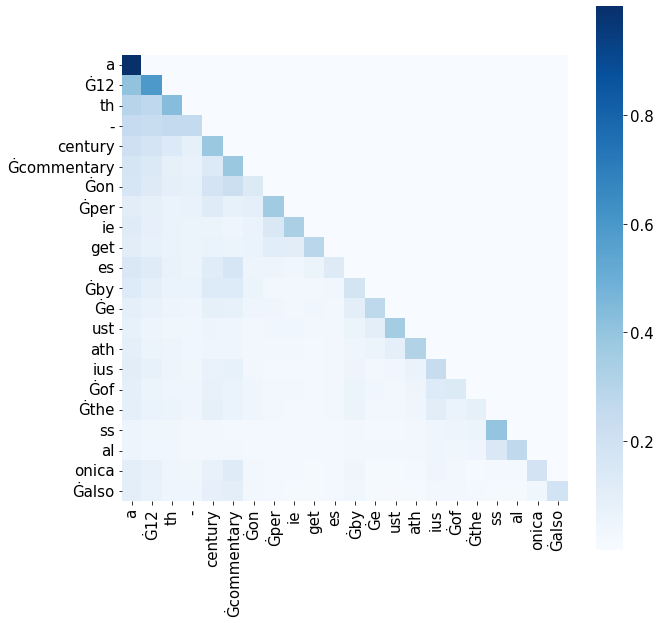

In [24]:
import seaborn as sns
# Show ALTI input attributions to model outputs 
df = pd.DataFrame(np.array(contributions_mix_alti[-1]),columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True);

In [25]:
# Compute ALTI-Logit
methods_decomp = ['aff_x_j'] # Logits Affine part of layer-wise decomposition
alti_lg_dict = track2input_tokens(logit_trans_vect_dict, methods_decomp, contributions_mix_alti, token)
alti_lg_dict.keys()

dict_keys(['logit_aff_x_j', 'logit_aff_x_j_alti'])

tensor(-0.0202)


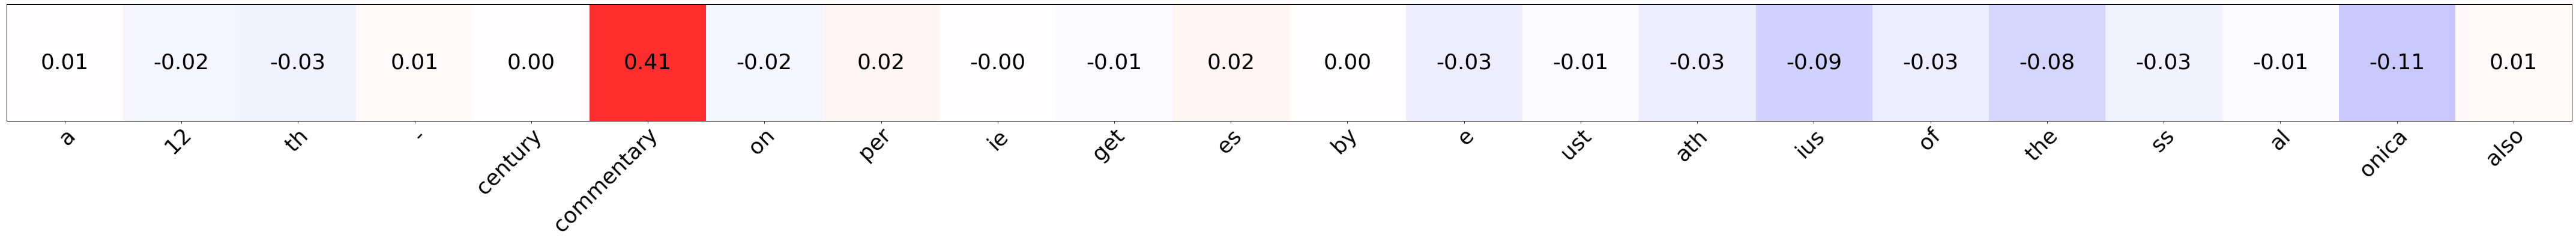

In [27]:
# 'logit_aff_x_j_alti' ALTI-Logit explanation
# 'logit_aff_x_j' Logit explanation
method = 'logit_aff_x_j'

# Contrastive explanation
contrastive_contributions = (alti_lg_dict[method][0] - alti_lg_dict[method][1]).sum(0)

# Add inital logit update by last postion intial embedding (see Eq. 7 paper)
init_logits_diff = (logits_modules['init_logit'][0] - logits_modules['init_logit'][1]).to('cpu')
contrastive_contributions[-1] += init_logits_diff
print(contrastive_contributions.sum())

# Normalization done in Kayo's work
# Divides by the sum of the absolute values (l1) of the explanations vector
norm = np.linalg.norm(contrastive_contributions, ord=1)
contrastive_contributions /= norm
explanations_list = []
explanations_list.append(contrastive_contributions)
# Yin and Neubig visualization (https://github.com/kayoyin/interpret-lm)
visualize(np.array(contrastive_contributions), tokenizer, [pt_batch["input_ids"][0]], print_text=True, normalize=False)
# Barplot visualization
#utils_contributions.plot_histogram(contrastive_contributions,tokenized_text)


In [16]:
# Plot in Latex
normalized_explanations, text_explanations = utils_contributions.normalize_contributions_for_visualization([contrastive_contributions], tokenized_text, word_level_contribs=True)
methods_list = [0]
methods_dict = {0: method}
text_explanations.append(r'\textbf{' + target + '}')
utils_contributions.figure_saliency(normalized_explanations, text_explanations, methods_list,methods_dict)

In [28]:
# Logits check
init_logit_token = logits_modules['init_logit'][0]
print('initial logit', init_logit_token)
mlp_logit_token_a = [logit_layer[0].item() for logit_layer in logits_modules['mlp_logit_layers']]
b_o_logit_token = [logit_layer[0].item() for logit_layer in logits_modules['b_o_logits_layers']]
print('b_o logit', sum(b_o_logit_token))
print('mlps logit', sum(mlp_logit_token_a))
print('self-attn layers logit', alti_lg_dict['logit_aff_x_j'][0].sum(0).sum())
print('lnf_bias logit', logits_modules['lnf_bias'][0])

alti_lg_dict['logit_aff_x_j'][0].sum(0).sum() + sum(mlp_logit_token_a) + init_logit_token + logits_modules['lnf_bias'][0] + sum(b_o_logit_token)

initial logit tensor(0.9604, device='cuda:0')
b_o logit -1.723979802802205
mlps logit -46.90460575371981
self-attn layers logit tensor(-46.2542)
lnf_bias logit tensor(-10.0599, device='cuda:0')


tensor(-103.9822, device='cuda:0')

### Yin and Neubig, 2022 methods

In [29]:
input = input.strip() + " "
input_tokens = tokenizer(input)['input_ids']
attention_ids = tokenizer(input)['attention_mask']
#preds = model_preds(model, [input_tokens], [attention_ids], -1, tokenizer, foils=None, k=10, verbose=True)

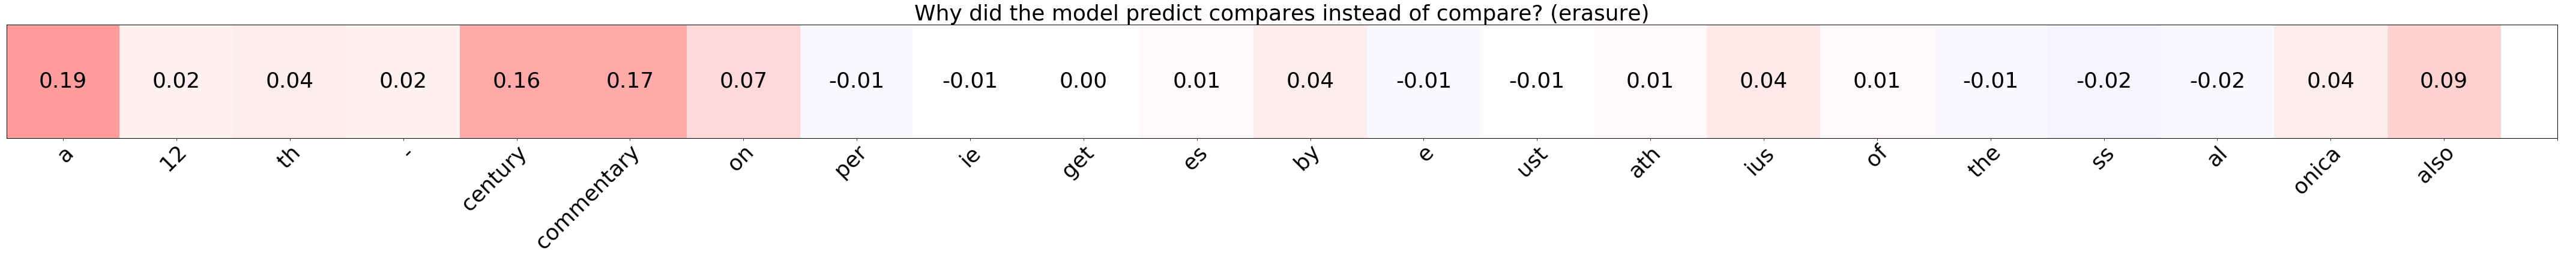

/home/usuaris/veu/javier.ferrando/anaconda3/envs/alti/lib/python3.7/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


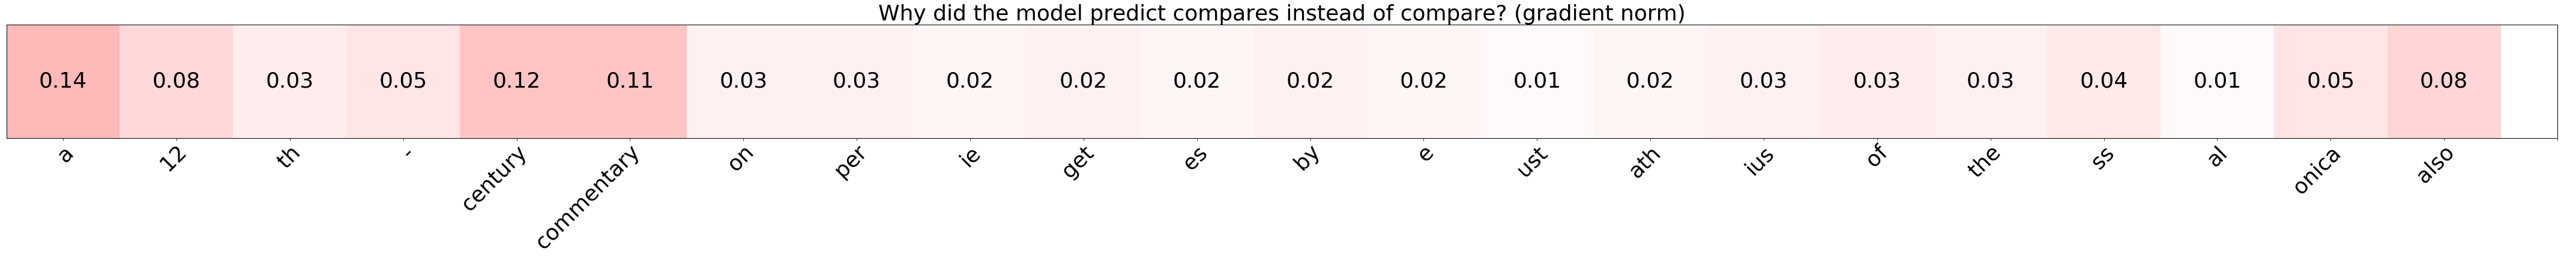

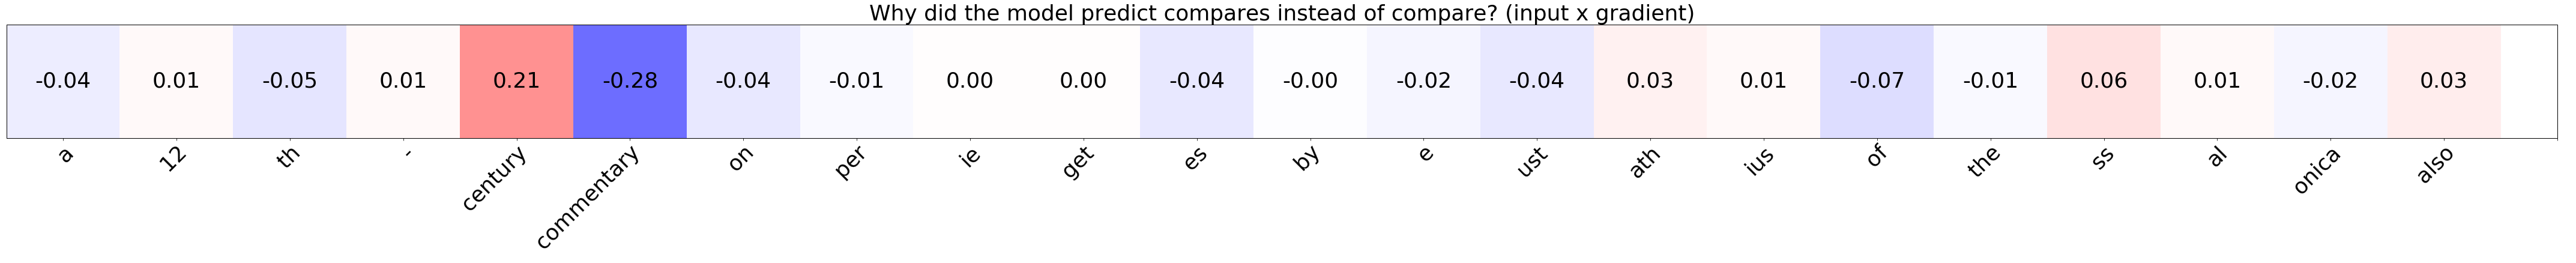

In [30]:
explanations = ["erasure", "gradient norm", "input x gradient"]

for explanation in explanations:
  if explanation == "erasure":
    base_explanation = erasure_scores(model, input_tokens, attention_ids, normalize=True)
    contra_explanation = erasure_scores(model, input_tokens, attention_ids, correct=CORRECT_ID, foil=FOIL_ID, normalize=True)
  else:
    #base_saliency_matrix, base_embd_matrix = saliency(model, input_tokens, attention_ids, correct=CORRECT_ID)
    saliency_matrix, embd_matrix = saliency(model, input_tokens, attention_ids, correct=CORRECT_ID, foil=FOIL_ID)
    if explanation == "input x gradient":
      #base_explanation = input_x_gradient(base_saliency_matrix, base_embd_matrix, normalize=True)
      contra_explanation = input_x_gradient(saliency_matrix, embd_matrix, normalize=True)
    elif explanation == "gradient norm":
      #base_explanation = l1_grad_norm(base_saliency_matrix, normalize=True)
      contra_explanation = l1_grad_norm(saliency_matrix, normalize=True)

  explanations_list.append(contra_explanation)
  #visualize(np.array(base_explanation), tokenizer, [input_tokens], print_text=True, title=f"Why did the model predict {target}? ({explanation})")
  visualize(np.array(contra_explanation), tokenizer, [input_tokens], print_text=True, title=f"Why did the model predict {target} instead of {foil}? ({explanation})")



In [20]:
# Create heatmap tables for paper
# Methods comparison plot
normalized_explanations, text_explanations = utils_contributions.normalize_contributions_for_visualization(explanations_list, tokenized_text)
text_explanations.append(r'\textbf{' + target + '}')
methods_list = [0,1,2,3]
methods_dict = {0: 'ALTI-Logit', 1: 'Erasure', 2: 'Grad Norm', 3: '\gradinput'}
utils_contributions.figure_saliency(normalized_explanations, text_explanations, methods_list,methods_dict)

## Layer-wise logit difference updates

In [21]:
# Layer-wise contributions of input tokens
method = 'aff_x_j'
layerwise_contrib_diff = (logit_trans_vect_dict[method][:,:, 0,:] - logit_trans_vect_dict[method][:,:, 1,:])[:,-1,:]
# for layer in range(0,layerwise_contrib_diff.shape[0]):
#     ax = utils_contributions.plot_histogram(layerwise_contrib_diff[layer],tokenized_text)
#     ax.set_title(layer+1)

# Create heatmap tables for paper
# Layer-wise plot
# Compute mean and max across layers
mean = np.array(layerwise_contrib_diff.flatten().mean())
max = np.array(layerwise_contrib_diff.flatten().max())
normalized_layerwise_contrib_diff, text_explanations = utils_contributions.normalize_contributions_for_visualization(layerwise_contrib_diff, tokenized_text, mean=mean, max=max, bos=bos_model)
text_explanations.append(r'\textbf{' + target + '}')
layers_dict = {}
for layer in range(layerwise_contrib_diff.shape[0]):
    layers_dict[layer] = 'L' + str(layer+1)
utils_contributions.figure_saliency_layers(normalized_layerwise_contrib_diff, text_explanations, methods_list, layers_dict)

## Head-wise logit difference updates

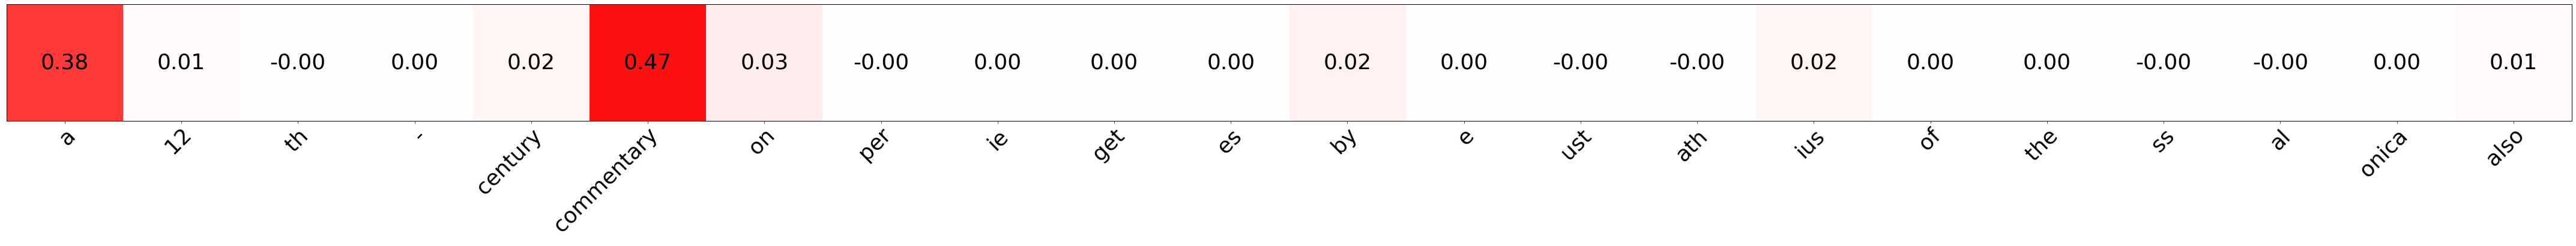

In [22]:
# Head level logit updates
logit_attn_heads_simp = logit_trans_vect_dict['aff_x_j_h']
layer = 10
head = 6
head_logit_diff = logit_attn_heads_simp[layer,head,-1,0] -logit_attn_heads_simp[layer,head,-1,1]

norm = np.linalg.norm(head_logit_diff, ord=1)
head_logit_diff /= norm

# Yin and Neubig visualization (https://github.com/kayoyin/interpret-lm)
visualize(np.array(head_logit_diff), tokenizer, [pt_batch["input_ids"][0]], print_text=True, normalize=False)

normalized_explanations, text_explanations = utils_contributions.normalize_contributions_for_visualization([head_logit_diff], tokenized_text, word_level_contribs=True)
methods_list = [0]
methods_dict = {0: 'Head-level Logit Update'}
text_explanations.append(r'\textbf{' + target + '}')
utils_contributions.figure_saliency(normalized_explanations, text_explanations, methods_list,methods_dict)